In [1]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Training

## load the dataset

In [2]:
import torchvision
from torchvision import datasets, transforms


def load_MNIST(data_dir, split, batch_size, shuffle, kwargs={}):
    """ Load and preprocess MNIST data, return data loader. """

    train_flag= True if split=='train' else False
    transform= transforms.Compose(
        [transforms.ToTensor(), 
         transforms.Normalize((0.1307,), (0.3081,))
         ])
    dataset= datasets.MNIST(data_dir, train=train_flag, 
                            download=True, transform=transform)
    
    if batch_size ==0:  batch_size = len(dataset) # load full test set
    data_loader= torch.utils.data.DataLoader(dataset, 
                                             batch_size = batch_size, 
                                             shuffle = shuffle, 
                                             **kwargs)
    return data_loader


data_dir = './data'
input_size= 28**2
num_classes = 10

mbs = 128

train_loader = load_MNIST(data_dir, 'train', mbs, shuffle=True)
test_loader  = load_MNIST(data_dir, 'test', 0, shuffle=False)


In [3]:
# how to get a single minibatch from the data loader
_inputs, _labels = next(iter(train_loader))

## plot some examples from the training set

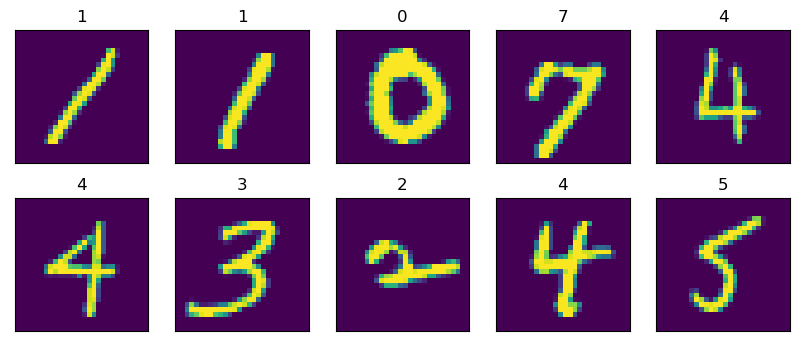

In [4]:
g = torch.Generator().manual_seed(4)

ind = torch.randperm(len(_labels), generator=g)[:10]
xs, ys = _inputs[ind], _labels[ind]


fig, axs = plt.subplots(2,5, figsize=(10,4))

for i, ax in enumerate(axs.flatten()):

    x = xs[i][0]
    y = ys[i]
    ax.imshow(x)

    ax.set_title(y.item())
    
    ax.set_xticks([])
    ax.set_yticks([])


## plot samples from one class

In [5]:
# this loads the entire test set (10k), because it is not mini-batched
_inputs, _labels = next(iter(test_loader))

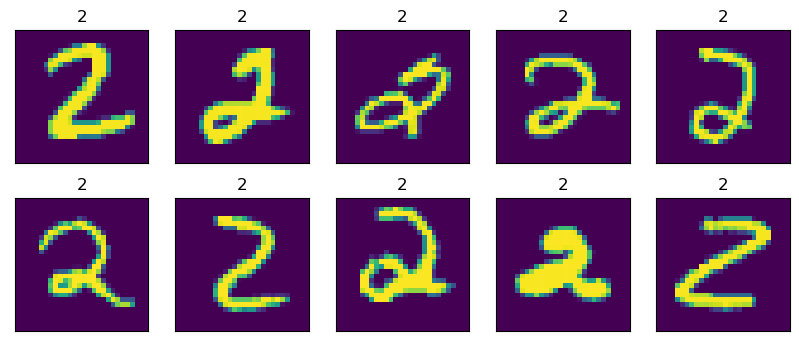

In [6]:
g = torch.Generator().manual_seed(4)

target_class = 2
target_inds = torch.where(_labels== target_class)[0]
selection = torch.randperm(len(target_inds), generator=g)[:10]
xs, ys = _inputs[target_inds[selection]], _labels[target_inds[selection]]


fig, axs = plt.subplots(2,5, figsize=(10,4))

for i, ax in enumerate(axs.flatten()):

    x = xs[i][0]
    y = ys[i]
    ax.imshow(x)

    ax.set_title(y.item())
    
    ax.set_xticks([])
    ax.set_yticks([])



## define model

In [7]:
class miniNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(28*28, 32, bias=False)
        self.layer2 = nn.Linear(32, 10, bias=False)
        self.actfun = nn.ReLU()

        self.layers = [self.layer1, self.layer2]

        # for pruning
        self.layer1.mask = None
        self.layer2.mask = None
        
    @torch.no_grad()
    def apply_mask(self):
        for layer in self.layers:
            layer.weight *= layer.mask
        
    def forward(self, x):
        x = self.flatten(x) # flattens along all dimensions except the 0-th (the batch dim)
        out = self.layer1(x)
        out = self.actfun(out)
        out = self.layer2(out)

        return out
    

In [ ]:
model = miniNet()

for p in model.named_parameters():
    print(f'{p[0]:15s} {p[1].shape}')

# for p in model.parameters():
#     print(p.shape)

## train model

In [ ]:
lr = 0.5

optimizer = torch.optim.SGD(model.parameters(), lr = lr) 
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,35], gamma=0.1)
lossfun = nn.CrossEntropyLoss()

In [ ]:
max_epochs = 40 # number of training epochs

step_counter = 0 # counting training iterations (gradient updates done)
epoch = 0

model.train()
while epoch <= max_epochs:
    loss_sum, total, correct = 0, 0, 0

    for mbi, mini_batch in enumerate(train_loader):
        step_counter += 1
        images, labels = mini_batch
        
        #=== forward pass
        outputs = model(images)
        loss = lossfun(outputs, labels)
        loss_sum += len(labels) * loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += len(labels)

        #=== backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #==== epoch completed.

    train_loss = loss_sum/total
    train_acc = correct/total
    
    print(f'=== epoch {epoch:3}:  Loss {train_loss:.2f}  Acc {train_acc:.4f}')

    scheduler.step()
    epoch += 1 


## evaluate trained model

In [ ]:
model.eval()
loss_sum, total, correct = 0, 0, 0

for images, labels in test_loader:
    
    outputs = model(images)
    loss = lossfun(outputs, labels)
    loss_sum += len(labels) * loss.item()
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).cpu().sum().item()
    total += len(labels)

test_loss = loss_sum/total
test_acc = correct/total

print(f'Final Test Result:    Loss {test_loss:.2f}  Acc {test_acc:.4f}')

## save model checkpoint

In [ ]:
import os

def save_checkpoint(state, savepath):
    """Save model checkpoint."""
    # create (sub)dirs if not yet existent
    savedir = os.path.dirname(savepath)
    if not os.path.exists(savedir):
        os.mkdir(savedir)
    torch.save(state, f'{savepath}.ckpt')



state= {'epoch': epoch, 
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(), 
        'scheduler': scheduler.state_dict(),
        'test_loss': test_loss, 
        'test_acc': test_acc
        }

save_name= './checkpoints/final'
save_checkpoint(state, save_name)


## load model from checkpoint

In [8]:
# load model from checkpoint

model = miniNet()

lr = 0.5
optimizer = torch.optim.SGD(model.parameters(), lr = lr) 
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,35], gamma=0.1)
lossfun = nn.CrossEntropyLoss()

save_name= './checkpoints/final'
checkpoint = torch.load(save_name+'.ckpt')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
# scheduler.load_state_dict(checkpoint['scheduler'])

epoch = checkpoint['epoch']
loss = checkpoint['test_loss']
acc = checkpoint['test_acc']

model.eval()

miniNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=32, bias=False)
  (layer2): Linear(in_features=32, out_features=10, bias=False)
  (actfun): ReLU()
)

# Pruning

In [ ]:
"""
"pruning a weight" means setting its value to zero and keeping it fixed - that is, 
it will not be updated in further training steps.
we implement pruning with masks: a mask is a binary-valued tensor of the same 
shape as the associated weight tensor, with "1" for weights that are to be kept 
and "0" for weights that are to be pruned. it is applied to the weight tensor by 
element-wise multiplication. note that we need to wrap the pruning operation in 
torch.no_grad(), otherwise autograd will complain.

how do we choose which weights to prune? there is a number of different possible 
criteria. we shall focus on magnitude-based weight pruning post training, a simple 
and effective pruning technique: the model is first trained. then, a certain number
of weights with the smallest magnitude are pruned. after that, an additional couple
steps of training are done to fine-tune (adjust) the remaining non-pruned weights. 
doing a single pruning step is called "1-shot pruning". alternatively, one can turn 
this into an iterative process, where pruning followed by fine-tuning is repeated 
multiple times until the desired sparsity is reached. the iterative process is more 
expensive, but also yields better results.

the number of weights to prune in every iteration is arbitrary and is to be chosen 
depending on the details of the procedure and the goal. typically, the goal is to 
reduce the number of weights as much as possible while maintaining model accuracy. 
how many weights can be pruned without incurring any damage to the model depends 
on many details and can usually only be determined empirically in experiments. in 
general, pruning a large fraction of weights 1-shot is more damaging than pruning 
the same fraction of weights over multiple prune-train iterations. as a rule of 
thumb, pruning 20% is often a good starting point.

a note on naming conventions:
a model with some fraction of its weights pruned is called "sparse", while a model 
with all its weights present is called "dense". 
sparsity (of the model, or of a weight tensor) is defined as the fraction of pruned 
weights: that is, a dense model is 0.0 sparse; after pruning 20%, the model is 0.2 
sparse etc. the opposite of sparsity is sometimes called "connectivity", defined as 
the fraction of the original weights remaining: connectivity = 1 - sparsity.

before implementing magnitude-based pruning, we analyse the trained model's weights 
in a couple of plots.
"""

## plotting the weights

In [ ]:
W = model.layer2.weight.data.detach()

fig, axs = plt.subplots(2,1, figsize=(8,7))

ax = axs[0]
im = ax.imshow(W, cmap='seismic', vmin = - abs(W).max(), vmax = abs(W).max())
plt.colorbar(im, orientation='horizontal', location='top', pad=0.07, aspect=50)


ax = axs[1]
im = ax.imshow(abs(W), cmap='Reds', vmin = abs(W).min(), vmax = abs(W).max())
plt.colorbar(im, orientation='horizontal', location='top', pad=0.07, aspect=50)

plt.show()



In [ ]:
absw = sorted(abs(W.flatten()))
w = sorted(W.flatten())

pp = 0.5
k = int(pp * W.numel())

# get the indices and values of the p smallest elements from abs(W)
vals, inds = torch.topk(abs(W).flatten(), k, largest=False)

mi = W.flatten()[inds].min()
ma = W.flatten()[inds].max()

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(absw, 'ro', label='abs(w)')
ax.plot(w, 'bo', label='w')

# add weights-to-prune
ax.plot(sorted(abs(W).flatten()[inds]), 'x', color='cyan', label='to-prune')
ax.axhline(mi, c='k', linewidth=0.8)
ax.axhline(ma, c='k', linewidth=0.8)

ax.legend()
ax.set_title('sorted weights from layer 2')
plt.show()

## make layer masks

In [92]:
# load model from checkpoint

model = miniNet()

lr = 0.5
optimizer = torch.optim.SGD(model.parameters(), lr = lr) 
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,35], gamma=0.1)
lossfun = nn.CrossEntropyLoss()

save_name= './checkpoints/final'
checkpoint = torch.load(save_name+'.ckpt')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
# scheduler.load_state_dict(checkpoint['scheduler'])

epoch = checkpoint['epoch']
loss = checkpoint['test_loss']
acc = checkpoint['test_acc']

model.eval()

miniNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=32, bias=False)
  (layer2): Linear(in_features=32, out_features=10, bias=False)
  (actfun): ReLU()
)

In [93]:
prune_fract = 0.5  # fraction of weights to prune per layer
inds_magn={}

for l, layer in enumerate(model.layers):

    layer.mask = torch.ones(layer.weight.shape, dtype = torch.bool) # all True (1) = all weights kept

    # the number of weights to prune
    k = int(prune_fract * layer.weight.numel()) 

    # get indices and values of the k smallest elements from abs(W)
    vals, inds = torch.topk(abs(layer.weight).flatten(), k, largest=False)
    
    # setting mask to False (0) for weights to be removed
    layer.mask.view(-1)[inds] = False

    inds_magn[l] = inds

In [51]:
# check fraction of ones in masks (= weights to keep)
for layer in model.layers:
    s = torch.sum(layer.mask)/layer.weight.numel()
    print(s)

tensor(0.5000)
tensor(0.5000)


## prune model

In [12]:
for l,layer in enumerate(model.layers):
    print(torch.sum(layer.weight != 0))

tensor(25088)
tensor(320)


In [13]:
model.apply_mask()

In [14]:
for l,layer in enumerate(model.layers):
    print(f'=== layer {l+1} ===')
    numw_tot = layer.weight.numel()
    numw_nonz = torch.sum(layer.weight != 0).item()
    conn = (torch.sum(layer.weight != 0) / layer.weight.numel()).item()
    print(f'{numw_tot} - {numw_nonz} = {numw_tot-numw_nonz}')
    print(f'1-sparsity = {conn:.2f}')

=== layer 1 ===
25088 - 12544 = 12544
1-sparsity = 0.50
=== layer 2 ===
320 - 160 = 160
1-sparsity = 0.50


## eval pruned model

In [15]:
loss_sum, total, correct = 0, 0, 0

for images, labels in test_loader:
    
    outputs = model(images)
    loss = lossfun(outputs, labels)
    loss_sum += len(labels) * loss.item()
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).cpu().sum().item()
    total += len(labels)

test_loss = loss_sum/total
test_acc = correct/total

print(f'Test Result pre  pruning:  Loss {checkpoint["test_loss"]:.2f}  Acc {checkpoint["test_acc"]:.4f}')
print(f'Test Result post pruning:  Loss {test_loss:.2f}  Acc {test_acc:.4f}')

Test Result pre  pruning:  Loss 0.17  Acc 0.9594
Test Result post pruning:  Loss 0.20  Acc 0.9493


## compare magnitude-based pruning to random pruning

### load model checkpoint

In [114]:
model = miniNet()

lr = 0.5
optimizer = torch.optim.SGD(model.parameters(), lr = lr) 
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,35], gamma=0.1)
lossfun = nn.CrossEntropyLoss()

save_name= './checkpoints/final'
checkpoint = torch.load(save_name+'.ckpt')
model.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
# scheduler.load_state_dict(checkpoint['scheduler'])

epoch = checkpoint['epoch']
loss = checkpoint['test_loss']
acc = checkpoint['test_acc']

model.eval()

miniNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=32, bias=False)
  (layer2): Linear(in_features=32, out_features=10, bias=False)
  (actfun): ReLU()
)

### make and compare various pruning masks

In [115]:
def pruning_inds(weights, criterion, prune_fract):
    """
    Select weights to prune in a given weight tensor given pruning criterion.
    Returns a list of indices (flattened) of the weights to prune.
    Args:
        weights (torch tensor, 2d): weights tensor
        criterion (str): pruning criterion
        prune_fract (float): fraction of weights to prune, value between 0 and 1
    """

    if criterion=='min_magn': # prune weights with smallest magnitude
        k = int(prune_fract * layer.weight.numel()) 
        _, prune_inds = torch.topk(abs(weights).flatten(), k, largest=False)

    elif criterion=='max_magn': # prune weights with largest magnitude
        k = int(prune_fract * layer.weight.numel()) 
        _, prune_inds = torch.topk(abs(weights).flatten(), k, largest=True)

    elif criterion=='random':
        g = torch.Generator().manual_seed(45345234)
        numw = weights.numel()
        k = int(prune_fract * numw)
        prune_inds = torch.randperm(numw, generator=g)[:k]

    return prune_inds

In [139]:
prune_fract = 0.45  # fraction of weights to prune per layer
prune_crits = ['min_magn', 'max_magn', 'random']
prune_inds = {pcr: {} for pcr in prune_crits}

for l, layer in enumerate(model.layers):
    for pcr in prune_crits:
        # get indices of weights to be pruned
        prune_inds[pcr][l] = pruning_inds(layer.weight, pcr, prune_fract)


In [145]:
# check number of indices (= weights to keep)
for pcr in prune_crits:
    print(f'=== {pcr} ===')
    for l, layer in enumerate(model.layers):
        s = len(prune_inds[pcr][l])/layer.weight.numel()
        print(f'{s:.4f}')

=== min_magn ===
0.4500
0.4500
=== max_magn ===
0.4500
0.4500
=== random ===
0.4500
0.4500


In [192]:
def num_common_inds(list1, list2):
    "count the number of common elements in two lists"
    return len(list(set(list1).intersection(list2)))


print('Number of common pruned weights\nbetween different pruning criteria:\n')
l =0
for i in range(3):
    for j in range(i+1,3):

        list1 = prune_inds[prune_crits[i]][l].tolist()
        list2 = prune_inds[prune_crits[j]][l].tolist()
        nc = num_common_inds(list1, list2)
        print(f'{prune_crits[i]} -&- {prune_crits[j]}:  {nc} / {len(list1)} = {100*nc/len(list1):.2f}%')

Number of common pruned weights
between different pruning criteria:

min_magn -&- max_magn:  0 / 11289 = 0.00%
min_magn -&- random:  5094 / 11289 = 45.12%
max_magn -&- random:  5060 / 11289 = 44.82%


### plot pruned weights for different criteria

In [206]:
prune_crits

['min_magn', 'max_magn', 'random']

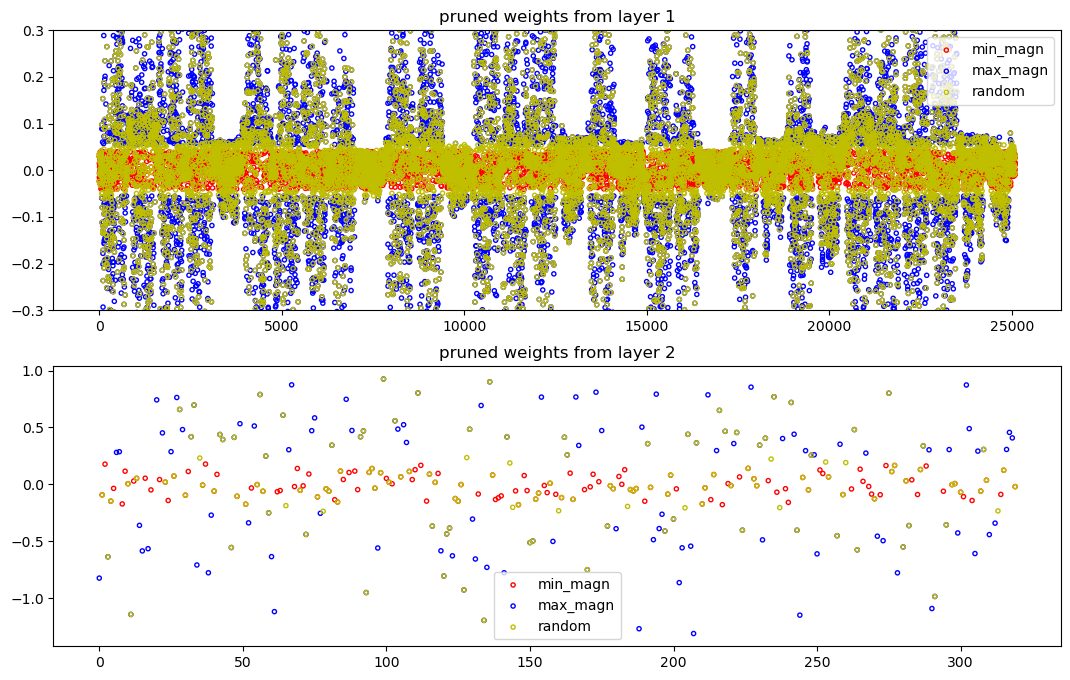

In [215]:
fig, axs = plt.subplots(2,1, figsize=(13,8))
m = ['.','.','.']
mec = ['r','b','y']

for l in range(2):
    W = model.layers[l].weight.detach()
    ax = axs[l]
    for i,pcr in enumerate(prune_crits):

        inds = prune_inds[pcr][l]
        ax.scatter(inds, W.view(-1)[inds], label=pcr,
                   marker=m[i], edgecolor=mec[i], facecolor='none')

    ax.legend()
    if l==0: ax.set_ylim([-0.3,0.3])
    ax.set_title(f'pruned weights from layer {l+1}')
plt.show()


### prune and eval model